# Prediction of the utilization using Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

### Cross validation and normalizing

We will perform the predictions for site 1 and site 2 separately, because they have different characteristics. 
The random state parameter means that the cross validation is reproducible and can be performed in the same way for the prediction using polynomial regression.

In [2]:
# read in the preprocessed data
Input_hourly = pd.read_csv('input_hourly.csv', parse_dates=['date'])

# split into input and output
X_site1 = Input_hourly.drop(["time_id", "date", "site1_utilization_percentage", "site2_utilization_percentage"], axis=1)
y_site1 = Input_hourly["site1_utilization_percentage"]

X_site2 = Input_hourly.drop(["time_id", "date", "site1_utilization_percentage", "site2_utilization_percentage"], axis=1)
y_site2 = Input_hourly["site2_utilization_percentage"]

# cross-validation
X_train_site1, X_test_site1, y_train_site1, y_test_site1 = train_test_split(X_site1, y_site1, test_size=0.3, random_state=42)

X_train_site2, X_test_site2, y_train_site2, y_test_site2 = train_test_split(X_site2, y_site2, test_size=0.3, random_state=42)

# normalize the data, save the original values and delete columns
X_train_site1_original = X_train_site1.copy()
X_test_site1_original = X_test_site1.copy()

X_train_site1 = X_train_site1.drop(["hour", "month", "dayOfTheWeek"], axis=1)
X_test_site1 = X_test_site1.drop(["hour", "month", "dayOfTheWeek"], axis=1)

scaler_site1 = StandardScaler()
scaler_site1.fit(X_train_site1)

X_train_site1 = scaler_site1.transform(X_train_site1)
X_test_site1 = scaler_site1.transform(X_test_site1)

X_train_site2_original = X_train_site2.copy()
X_test_site2_original = X_test_site2.copy()

X_train_site2 = X_train_site2.drop(["hour", "month", "dayOfTheWeek"], axis=1)
X_test_site2 = X_test_site2.drop(["hour", "month", "dayOfTheWeek"], axis=1)

scaler_site2 = StandardScaler()
scaler_site2.fit(X_train_site2)

X_train_site2 = scaler_site2.transform(X_train_site2)
X_test_site2 = scaler_site2.transform(X_test_site2)

## Utilization prediction of site 1

### Model definition (site 1)

In [3]:
model_site1 = Sequential(
    [Dense(36, activation="relu", input_shape=[X_train_site1.shape[1]]),
    Dense(36, activation="relu"),
     Dense(1)])
model_site1.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])
model_site1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                1656      
                                                                 
 dense_1 (Dense)             (None, 36)                1332      
                                                                 
 dense_2 (Dense)             (None, 1)                 37        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


### Training the model (site 1)

Epoch 1/20
215/215 [==============================] - 2s 5ms/step - loss: 508.8492 - mae: 14.0020 - mse: 508.8492 - val_loss: 249.9444 - val_mae: 11.5873 - val_mse: 249.9444
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 155.9920 - mae: 8.3176 - mse: 155.9920 - val_loss: 139.2213 - val_mae: 7.3419 - val_mse: 139.2213
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 113.3895 - mae: 6.3512 - mse: 113.3895 - val_loss: 124.7394 - val_mae: 6.6884 - val_mse: 124.7394
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 104.9197 - mae: 5.8210 - mse: 104.9197 - val_loss: 117.8460 - val_mae: 6.2073 - val_mse: 117.8460
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 100.5608 - mae: 5.4398 - mse: 100.5608 - val_loss: 114.7788 - val_mae: 5.8784 - val_mse: 114.7788
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 97.9219 - mae: 5.1750 - mse: 97.9219 - val_loss: 113.0125 - val_

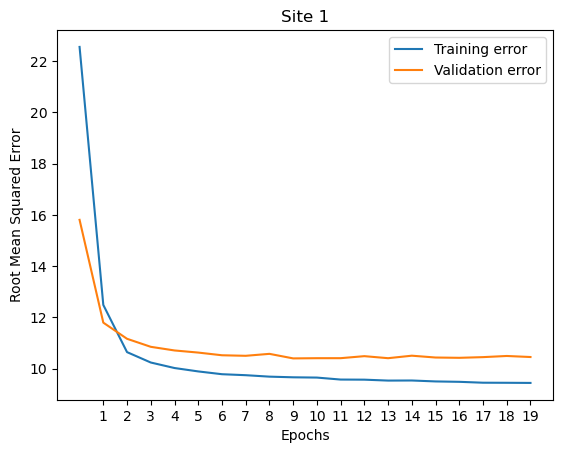

In [4]:
epochs_site1 = 20

# train the model
history_site1 = model_site1.fit(X_train_site1, y_train_site1.values,
                   epochs=epochs_site1, validation_split=0.2)
history_site1 = pd.DataFrame(history_site1.history)

# compute rmse
root_metrics_site1 = history_site1[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_site1.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)

# plot rmse of the training and validation set per epoch
plt.Figure(figsize=(14,6), dpi=100)
plt.plot(root_metrics_site1["rmse"], label = 'Training error')
plt.plot(root_metrics_site1["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("Site 1")

plt.xticks(range(1,20))
plt.legend()

plt.show()

### Prediction (site 1)

In [5]:
# prediction using the trained model
y_pred_site1 = model_site1.predict(X_test_site1)

115/115 [==============================] - 0s 2ms/step


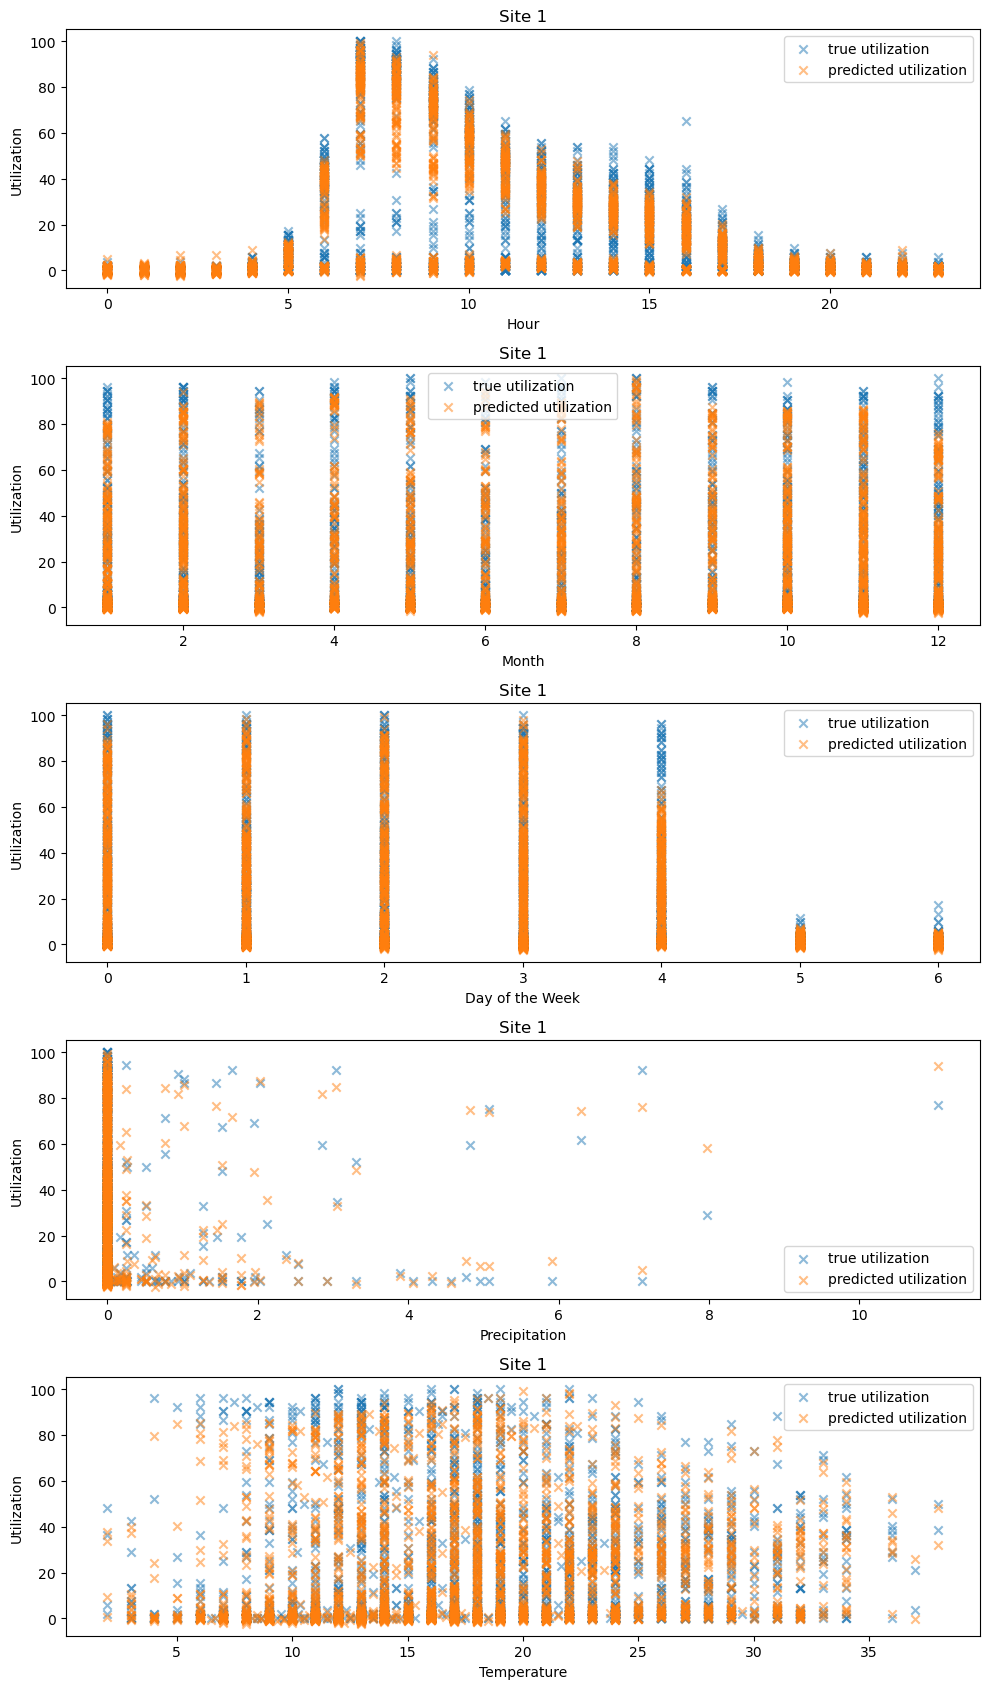

In [6]:
# subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 17), sharey=True)

# "hour"
axs[0].scatter(X_test_site1_original['hour'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[0].scatter(X_test_site1_original['hour'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[0].set_title('Site 1')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Utilization')

# "month"
axs[1].scatter(X_test_site1_original['month'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[1].scatter(X_test_site1_original['month'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[1].set_title('Site 1')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Utilization')

# "dayOfTheWeek"
axs[2].scatter(X_test_site1_original['dayOfTheWeek'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[2].scatter(X_test_site1_original['dayOfTheWeek'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[2].set_title('Site 1')
axs[2].set_xlabel('Day of the Week')
axs[2].set_ylabel('Utilization')

# "precipitation"
axs[3].scatter(X_test_site1_original['precipitation'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[3].scatter(X_test_site1_original['precipitation'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[3].set_title('Site 1')
axs[3].set_xlabel('Precipitation')
axs[3].set_ylabel('Utilization')

# "temperature"
axs[4].scatter(X_test_site1_original['temperature'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[4].scatter(X_test_site1_original['temperature'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[4].set_title('Site 1')
axs[4].set_xlabel('Temperature')
axs[4].set_ylabel('Utilization')

# legend
for ax in axs.flat:
    ax.legend()

# layout
plt.tight_layout()
plt.show()

The features that influence the utilization the most are whether ist a weekday or the weekend and the hour. Therefore we look at these features in detail.

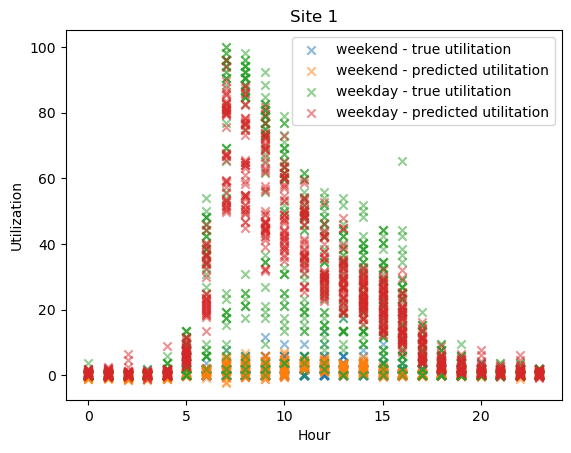

In [7]:
all_values = X_test_site1_original
all_values["true_utilization"] = y_test_site1
all_values["predicted_values"] = y_pred_site1
weekend_values = all_values[all_values['dayOfTheWeek'].isin([5, 6])]
weekday_values = all_values[all_values['dayOfTheWeek'].isin([0, 4])]

plt.scatter(weekend_values['hour'], weekend_values["true_utilization"], label='weekend - true utilitation', marker='x', alpha=0.5)
plt.scatter(weekend_values['hour'], weekend_values["predicted_values"], label='weekend - predicted utilitation', marker='x', alpha=0.5)
plt.scatter(weekday_values['hour'], weekday_values["true_utilization"], label='weekday - true utilitation', marker='x', alpha=0.5)
plt.scatter(weekday_values['hour'], weekday_values["predicted_values"], label='weekday - predicted utilitation', marker='x', alpha=0.5)

plt.xlabel('Hour')
plt.ylabel('Utilization')
plt.title('Site 1')
plt.legend()

plt.show()

### Evaluation (site 1)

In [8]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test_site1, y_pred_site1)))
print("MAE: ", mean_absolute_error(y_test_site1, y_pred_site1))
print("MAPE: ", mean_absolute_percentage_error(y_test_site1, y_pred_site1))

RMSE:  9.92107427805091
MAE:  4.7849928431707704
MAPE:  3806991187603740.5


## Utilization prediction of site 2

### Model definition (site 2)

In [9]:
model_site2 = Sequential(
    [Dense(36, activation="relu", input_shape=[X_train_site2.shape[1]]),
    Dense(36, activation="relu"),
     Dense(1)])
model_site2.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])
model_site2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 36)                1656      
                                                                 
 dense_4 (Dense)             (None, 36)                1332      
                                                                 
 dense_5 (Dense)             (None, 1)                 37        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


### Training the model (site 2)

Epoch 1/20
215/215 [==============================] - 1s 4ms/step - loss: 83.8218 - mae: 5.5565 - mse: 83.8218 - val_loss: 40.2892 - val_mae: 4.3287 - val_mse: 40.2892
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 38.8548 - mae: 3.9752 - mse: 38.8548 - val_loss: 31.6622 - val_mae: 3.6328 - val_mse: 31.6622
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 34.7157 - mae: 3.6535 - mse: 34.7157 - val_loss: 30.3376 - val_mae: 3.4835 - val_mse: 30.3376
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 33.3289 - mae: 3.5300 - mse: 33.3289 - val_loss: 30.0716 - val_mae: 3.4722 - val_mse: 30.0716
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 32.5827 - mae: 3.4636 - mse: 32.5827 - val_loss: 29.4764 - val_mae: 3.3731 - val_mse: 29.4764
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 31.8760 - mae: 3.4307 - mse: 31.8760 - val_loss: 29.0225 - val_mae: 3.3778 - val_mse: 

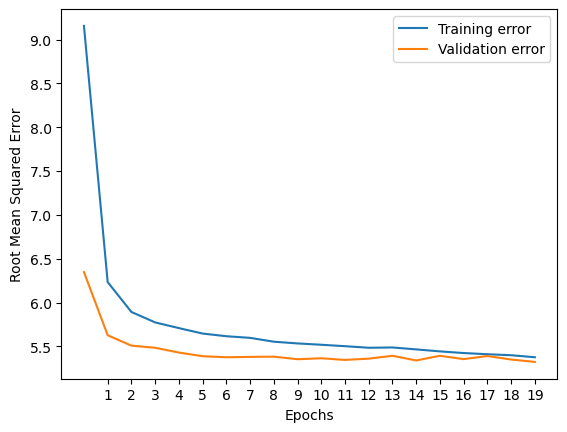

In [10]:
epochs_site2 = 20

# train the model
history_site2 = model_site2.fit(X_train_site2, y_train_site2.values,
                   epochs=epochs_site2, validation_split=0.2)
history_site2 = pd.DataFrame(history_site2.history)

# compute rmse
root_metrics_site2 = history_site2[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_site2.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)

# plot rmse of the training and validation set per epoch
plt.Figure(figsize=(14,6), dpi=100)
plt.plot(root_metrics_site2["rmse"], label = 'Training error')
plt.plot(root_metrics_site2["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(range(1,20))
plt.legend()

plt.show()

### Prediction (site 2)

In [11]:
# prediction using the trained model
y_pred_site2 = model_site2.predict(X_test_site2)

115/115 [==============================] - 0s 2ms/step


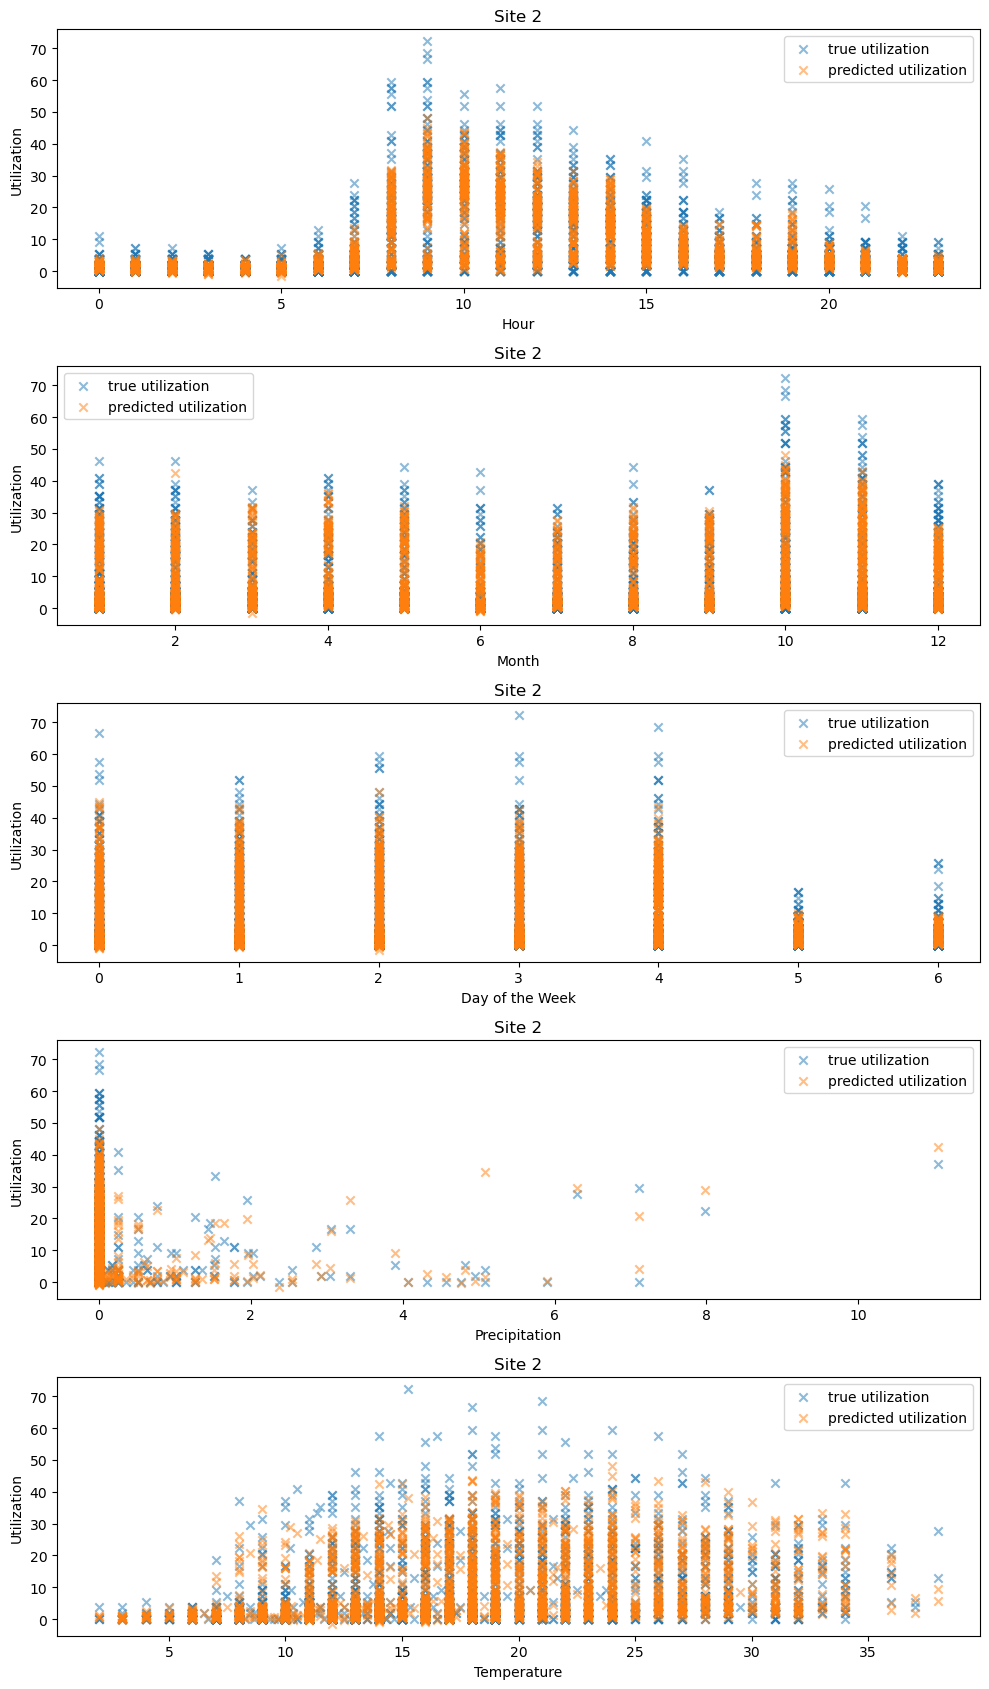

In [12]:
# subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 17), sharey=True)

# "hour"
axs[0].scatter(X_test_site2_original['hour'], y_test_site2, label='true utilization', marker='x', alpha=0.5)
axs[0].scatter(X_test_site2_original['hour'], y_pred_site2, label='predicted utilization', marker='x', alpha=0.5)
axs[0].set_title('Site 2')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Utilization')

# "month"
axs[1].scatter(X_test_site2_original['month'], y_test_site2, label='true utilization', marker='x', alpha=0.5)
axs[1].scatter(X_test_site2_original['month'], y_pred_site2, label='predicted utilization', marker='x', alpha=0.5)
axs[1].set_title('Site 2')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Utilization')

# "dayOfTheWeek"
axs[2].scatter(X_test_site2_original['dayOfTheWeek'], y_test_site2, label='true utilization', marker='x', alpha=0.5)
axs[2].scatter(X_test_site2_original['dayOfTheWeek'], y_pred_site2, label='predicted utilization', marker='x', alpha=0.5)
axs[2].set_title('Site 2')
axs[2].set_xlabel('Day of the Week')
axs[2].set_ylabel('Utilization')

# "precipitation"
axs[3].scatter(X_test_site2_original['precipitation'], y_test_site2, label='true utilization', marker='x', alpha=0.5)
axs[3].scatter(X_test_site2_original['precipitation'], y_pred_site2, label='predicted utilization', marker='x', alpha=0.5)
axs[3].set_title('Site 2')
axs[3].set_xlabel('Precipitation')
axs[3].set_ylabel('Utilization')

# "temperature"
axs[4].scatter(X_test_site2_original['temperature'], y_test_site2, label='true utilization', marker='x', alpha=0.5)
axs[4].scatter(X_test_site2_original['temperature'], y_pred_site2, label='predicted utilization', marker='x', alpha=0.5)
axs[4].set_title('Site 2')
axs[4].set_xlabel('Temperature')
axs[4].set_ylabel('Utilization')

# legend
for ax in axs.flat:
    ax.legend()

# layout
plt.tight_layout()
plt.show()

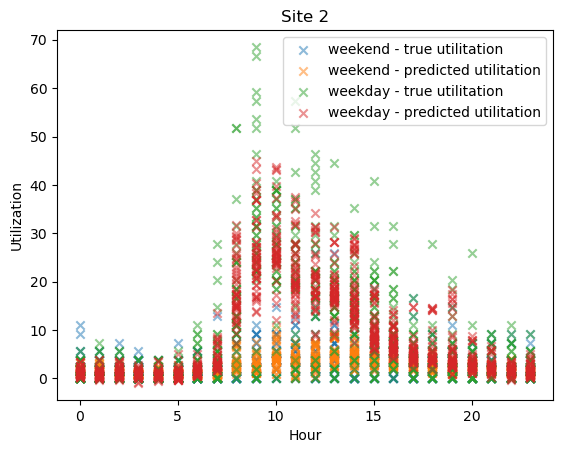

In [13]:
all_values = X_test_site2_original
all_values["true_utilization"] = y_test_site2
all_values["predicted_values"] = y_pred_site2
weekend_values = all_values[all_values['dayOfTheWeek'].isin([5, 6])]
weekday_values = all_values[all_values['dayOfTheWeek'].isin([0, 4])]

plt.scatter(weekend_values['hour'], weekend_values["true_utilization"], label='weekend - true utilitation', marker='x', alpha=0.5)
plt.scatter(weekend_values['hour'], weekend_values["predicted_values"], label='weekend - predicted utilitation', marker='x', alpha=0.5)
plt.scatter(weekday_values['hour'], weekday_values["true_utilization"], label='weekday - true utilitation', marker='x', alpha=0.5)
plt.scatter(weekday_values['hour'], weekday_values["predicted_values"], label='weekday - predicted utilitation', marker='x', alpha=0.5)

plt.xlabel('Hour')
plt.ylabel('Utilization')
plt.title('Site 2')
plt.legend()

plt.show()

### Evaluation (site 2)

In [14]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test_site2, y_pred_site2)))
print("MAE: ", mean_absolute_error(y_test_site2, y_pred_site2))
print("MAPE: ", mean_absolute_percentage_error(y_test_site2, y_pred_site2))

RMSE:  5.515769357489077
MAE:  3.4094712316018136
MAPE:  3078776384462743.0
